In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D,BatchNormalization, LSTM, CuDNNLSTM, MaxPooling2D
from keras.models import Sequential
from keras import regularizers
import keras

from keras.layers import TimeDistributed
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import matplotlib.pyplot as plt
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_dir = 'drive/MyDrive/archive/train'
val_dir = 'drive/MyDrive/archive/test'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_generator = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=2, 
    vertical_flip=2
)    

training_set = image_generator.flow_from_directory(batch_size=256,
                                                 directory=train_dir,
                                                 shuffle=True,
                                                 target_size=(48, 48), 
                                                 class_mode='categorical',
#                                                  color_mode = "grayscale"
                                                )

testing_set = image_generator.flow_from_directory(batch_size=128,
                                                 directory=val_dir,
                                                 shuffle=True,
                                                 target_size=(48, 48), 
                                                 class_mode='categorical',
#                                                  color_mode = "grayscale"
                                                 )

Found 28719 images belonging to 7 classes.
Found 2465 images belonging to 7 classes.


In [ ]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        train_dir,
        target_size=(48, 48),
        batch_size=64,
#         color_mode="grayscale",
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        val_dir,
        target_size=(48, 48),
        batch_size=64,
#         color_mode="grayscale",
        class_mode='categorical')

Found 28719 images belonging to 7 classes.
Found 2465 images belonging to 7 classes.


In [ ]:
dim = (48,48) # for MobileNetV2
n_sequence = 8 # for LSTM
n_channels = 3 # color channel(RGB)
n_output = 7 #18 # number of output class

In [ ]:
model = Sequential()    
model.add(tf.keras.layers.Reshape((1, 48, 48, 3), input_shape=(48, 48, 3)))
model.add( 
    TimeDistributed(
        MobileNetV2(weights='imagenet',include_top=False), 
        input_shape=(n_sequence, *dim, n_channels)
    )
)
model.add(
    TimeDistributed(
        GlobalAveragePooling2D()
    )
)
model.add(CuDNNLSTM(64, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(24, activation='relu'))
model.add(Dropout(.5))  
model.add(Dense(n_output, activation='softmax'))

In [ ]:

model.compile(optimizer = "adam",loss = "categorical_crossentropy" , metrics=['accuracy'])
hist = model.fit_generator(training_set, validation_data = testing_set , epochs = 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/5
113/113 [==============================] - 57s 446ms/step - loss: 1.8578 - accuracy: 0.2313 - val_loss: 2.2323 - val_accuracy: 8.1136e-04
Epoch 2/5
113/113 [==============================] - 48s 424ms/step - loss: 1.6470 - accuracy: 0.3567 - val_loss: 3.2510 - val_accuracy: 0.0057
Epoch 3/5
113/113 [==============================] - 49s 432ms/step - loss: 1.5204 - accuracy: 0.4196 - val_loss: 2.2783 - val_accuracy: 0.3318
Epoch 4/5
113/113 [==============================] - 49s 434ms/step - loss: 1.4615 - accuracy: 0.4438 - val_loss: 2.5299 - val_accuracy: 0.3724
Epoch 5/5
113/113 [==============================] - 49s 433ms/step - loss: 1.3997 - accuracy: 0.4706 - val_loss: 2.5848 - val_accuracy: 0.3878


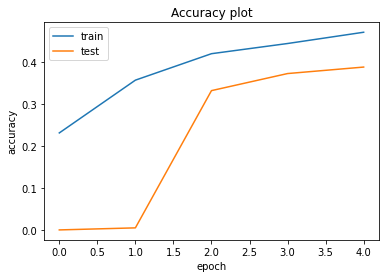

In [ ]:
hist = hist.history
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("mobilenetCuDNNLSTMv3_accuracy.png")

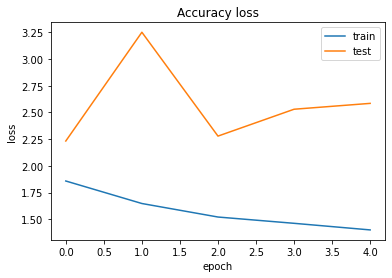

In [ ]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("mobilenetCuDNNLSTMv3_loss.png")

In [ ]:
model.save("mobilenetCuDNNLSTMv3.h5")